Quantum Approximation Optimization Algorithm and Max-Cut

**Max-Cut** is the problem of finding a partition of a graph's nodes into two sets which maximizes the edges b/w the two sets. It is **NP-hard** actually. QAOA can be adapted to this problem  

we take the convention that $G=(V,E)$ represents a graph with vertex set $V \subseteq  \mathbb{N}$ and edge set $E \subseteq V\times V$. We use the terms vertex and node interchangeably. For this tutorial, we assume that the graphs are undirected. Our graphs contain no self loops. A *cut* of the graph G is a partition $(V_0, V_1)$, of the vertex set such thaat every vertex of $V$ is a member of exactly one of $V_0$ or $V_1$ (i.e., $V_0 \cup V_1 = V$ and $ V_0\cap V_1 = 0$). The *cut value* for a partition is the sum of the edges with one node in $V_0$ and one node in $V_1$  

The number of edges connecting vertices sun the distinct sets is computed by
$$ \sum_{u\subset V_0; v\subset V_1;(u,v)\subset E}{1}$$
note that the max cut of a graph need not be unique; that is, two distinct partitions may produce the same cut value.  

We will use bitstrings to identify vertices in each of the two paritions. For example using the ordering of the vertices, the bitstring ```01100``` captures the partition  

Let's code our graph data as lists of integers so that we can call these variables when we create the ```cudaq.kernel``` for QAOA

In [18]:
import numpy as np
import cudaq
from cudaq import spin
from typing import List

# We'll use the graph below to illustrate how QAOA can be used to
# solve a max cut problem

#       v1  0--------------0 v2
#           |              | \
#           |              |  \
#           |              |   \
#           |              |    \
#       v0  0--------------0 v3-- 0 v4
# The max cut solutions are 01011, 10100, 01010, 10101 .

# First,we define the graph nodes an edges as lists of integers so taht they can be brodcasted into a cudaq.kerenl

# This is easy one
# nodes: List[int] = [0,1,2,3,4]
# edges = [[0,1],[1,2],[2,3],[3,0],[2,4],[3,4]]

# This is a bit more complex one
nodes=[0,1,2,3,4,5,6,7]
qubit_num=len(nodes)
edges=[[0,1],[0,2],[0,5],[0,6],[0,7],[1,2],[1,4],[1,6],[1,7],[2,4],[2,5],[2,7],[3,4],[3,5],[3,6],[4,5],[4,6],[5,6]]
#non_edges=[[u,v] for u in nodes for v in nodes if u<v and [u,v] not in edges]
edges_src: List[int] = [edges[i][0] for i in range(len(edges))]
edges_tgt: List[int] = [edges[i][1] for i in range(len(edges))]

QAOA is a variational algorithms with a particular ansatz. QAOA is made up of a variational quantum circuit(i.e., a kernel that depends on a set of parameter values) and a classical optimizer. The aim of QAOA is to use the classical optimizer to identify parameter values that generate a quantum circuit whose expectation value for a given cost Hamiltonian is minimized  

What distinguishes QAOA from other variational algorithms is the structure of the quantum circuit. For each vertex in the graph, there is an associated qubit in the circuit. The circuit is initialized in a superposition state. The remainder of the QAOA circuit is made up of blocks (referred to as layers). The more layers there are, the bertter the approximation the algorithm achieves.  

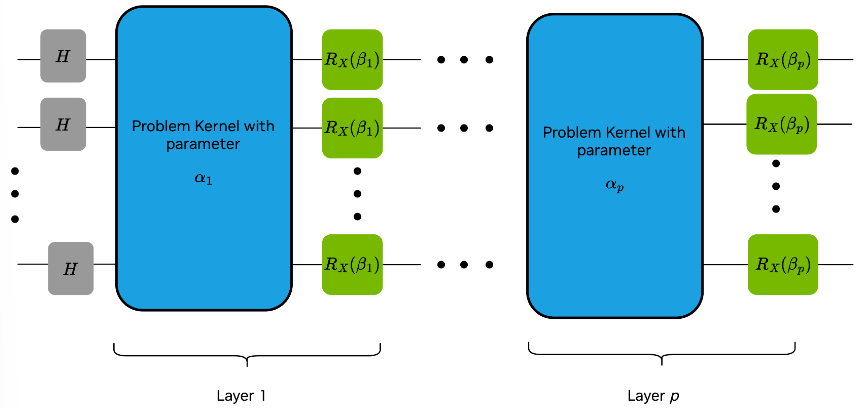  

Each layer contains a **problem** kernel and a **mixer** kernel. The mixer kernel is composed of parameterized rotation gates applied to each qubit. The problem kernel encodes the graph edges. The image below shows an example of an graph edge encode with controlled-X gates and a parameterized rotation gate  

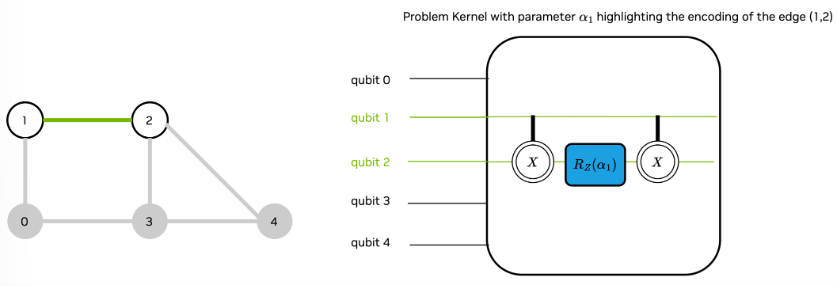  

Let's implement the QAOA circuit for our max cut problem in CUDA-Q

In [19]:
import cudaq
qubit_count: int = len(nodes)
layer_count: int = 2 # larger value will create deeper circuits
parameter_count: int =2 * layer_count # Each layer of the QAOA kernel contains 2 parameters

@cudaq.kernel
def qaoa(qubit_0: cudaq.qubit, qubit_1: cudaq.qubit, alpha: float):
    """
    Build the QAOA gate sequence b/w two qubits that represent an edge of the graph.

    Args:
        qubit_0 (cudaq.qubit): Qubit representing the first vertex of the edge
        qubit_1 (cudaq.qubit): Qubit representing the second vertex of the edge
        alpha: float: free variable

    Returns:
        None
    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# We now define the kernel_qaoa function which will be the QAOA circuit for our graph
# Since the QAOA circuit for max cut depends on the structure of the graph,
# we'll feed in global concrete variable values into the kernel_qaoa function for the qubit_count, layer_count, edges_src, edges_tgt.
# The types for these variables are restricted to Quake Values (e.g. qubit, int, List[int], ...)
# The thetas plaeholder will be our free parameters
@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, edges_src: List[int],
                edges_tgt: List[int], thetas: List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    Returns
    -------
    cudaq.Kernel
        QAOA circuit for Max-Cut for max cut of the graph with given edges and nodes
    """
    qreg = cudaq.qvector(qubit_count)
    
    h(qreg) # make superposition

    for i in range(layer_count):
        # add  the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = qreg[edges_src[edge]]
            qubitv = qreg[edges_tgt[edge]]
            qaoa(qubitu, qubitv, thetas[i])

        # add the mixer kernel to each layer
        for j in range(qubit_count):
            rx(2.0 * thetas[i + layer_count], qreg[j])

As mentioned eariler, QAOA is a variational algorithm that aims to minimize a cost function. To apply QAOA to the max cut proble. we assign a binary variable $z_v$ to each vertex v. These variables will take on the vales -1 or 1. Notice that an assignment of variable values coreesponds to a partition of the graph. For examle $\bar{z} = [-1,1,-1,1,1]$ would parition the graph into two sets: $\{0, 2\}$ and $\{1,3,4\}$. We can compute the cut value of the graph for an arbitrary assignment of variable values by the formulra:
$$C(\bar{z}) = \frac{1}{2} \sum_{(u,v)\subset E}{(1-z_u z_v)}$$
Where $E$ is the set of edges of our graph. Our goal is to find a variable assignment that maximizes $C(\bar{z})$. Equivalently, we want to find a variable assignment that minimizes $-C(\bar{z})$. Since QAOA identifies minimum values, we have reframed the max cut optimization problem from one of maximization to minimization. Futhermofr, we can promote this equation to a matrix equation by replacing $z_u z_v-1$ with Pauli-Z operators acting on qubits associated with nodes $u$ and $v$ , respectively, and replacing 1 with the identity matrix. This leads to the reformulation of the problem from one of maximigin $C(\bar{z})$ to one of minimizing the eigenvalues of
$$H = \frac{1}{2} \sum_{(u,v)\subseteq E}({Z_u Z_v - II})$$
We can code this Hamiltonian using ```cudaq.spin``` operators

In [20]:
def hamiltonian_max_cut(edges_src, edges_tgt):
    """
    Parameters
    ----------
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes

    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph with given edges
    """

    hamiltonian = 0
    for edge in range(len(edges_src)):
        qubitu = edges_src[edge]
        qubitv = edges_tgt[edge]

        hamiltonian += 0.5 * (spin.z(qubitu) * spin.z(qubitv) - spin.i(qubitu) * spin.i(qubitv))
    return hamiltonian

To initiate the QAOA algorithm, we need to identify initial parameters and specify the classical optimization routine

In [21]:
cudaq.set_random_seed(13)
optimizer = cudaq.optimizers.NelderMead()
np.random.seed(13)
optimizer.initial_parameters = np.random.uniform(-np.pi/8, np.pi/8, parameter_count)

print("Initial parameters:", optimizer.initial_parameters)


Initial parameters: [0.21810696323572243, -0.20613464375211488, 0.2546877639814583, 0.3657985647468064]


We can either use the ```observe``` primitive or the ```qve``` primitive to code up the optimization loop of QAOA

In [22]:
cudaq.set_target('nvidia')

hamiltonian = hamiltonian_max_cut(edges_src, edges_tgt)
print("Hamiltonian:\n", hamiltonian)

# Define the objective function
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian,
                        qubit_count, layer_count,
                        edges_src, edges_tgt, parameters).expectation()

optimal_expectation, optimal_parameters = optimizer.optimize(dimensions = parameter_count, function = objective)


print('optimal_expectation =', optimal_expectation)
print('Therefore, the max cut value is at least ', -1 * optimal_expectation)
print('optimal_parameters =', optimal_parameters)

Hamiltonian:
 (0.5+0i) * Z0Z1 + (-0.5+0i) * I0I1 + (0+0i) + (0.5+0i) * Z0Z2 + (-0.5+0i) * I0I2 + (0.5+0i) * Z0Z5 + (-0.5+0i) * I0I5 + (0.5+0i) * Z0Z6 + (-0.5+0i) * I0I6 + (0.5+0i) * Z0Z7 + (-0.5+0i) * I0I7 + (0.5+0i) * Z1Z2 + (-0.5+0i) * I1I2 + (0.5+0i) * Z1Z4 + (-0.5+0i) * I1I4 + (0.5+0i) * Z1Z6 + (-0.5+0i) * I1I6 + (0.5+0i) * Z1Z7 + (-0.5+0i) * I1I7 + (0.5+0i) * Z2Z4 + (-0.5+0i) * I2I4 + (0.5+0i) * Z2Z5 + (-0.5+0i) * I2I5 + (0.5+0i) * Z2Z7 + (-0.5+0i) * I2I7 + (0.5+0i) * Z3Z4 + (-0.5+0i) * I3I4 + (0.5+0i) * Z3Z5 + (-0.5+0i) * I3I5 + (0.5+0i) * Z3Z6 + (-0.5+0i) * I3I6 + (0.5+0i) * Z4Z5 + (-0.5+0i) * I4I5 + (0.5+0i) * Z4Z6 + (-0.5+0i) * I4I6 + (0.5+0i) * Z5Z6 + (-0.5+0i) * I5I6
optimal_expectation = -11.382193870537776
Therefore, the max cut value is at least  11.382193870537776
optimal_parameters = [0.18017054634595048, 0.4164290594488266, 1.1986640158906159, -0.2134569558528917]


Now that we have identified the optimal parameters, we can read out the paritioning(s) that gives us a max cur of the graph using ```sample``` primitive

In [23]:
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count,
                      edges_src, edges_tgt, optimal_parameters)
print(counts)

max_cut = max(counts, key = lambda x: counts[x])
print("One of the max cut solutions is:", max_cut)

{ 00000010:1 00000111:9 00001011:5 00001101:5 00001111:30 00010000:1 00010001:1 00010011:1 00010100:1 00010111:1 00011000:3 00011011:2 00011110:1 00100010:3 00100011:6 00100110:3 00100111:31 00101010:3 00101011:19 00101100:1 00101101:5 00101111:8 00110010:4 00110011:38 00110101:4 00110111:7 00111000:1 00111001:3 00111011:9 00111110:1 01000001:2 01000100:4 01000101:6 01000110:6 01000111:24 01001001:1 01001011:2 01001100:3 01001101:32 01001110:2 01001111:9 01010001:1 01010011:5 01010100:4 01010101:33 01010111:2 01011011:1 01011101:4 01011110:1 01100010:7 01100100:3 01100110:34 01100111:3 01101100:4 01101101:2 01110000:4 01110010:26 01110011:4 01110100:28 01110101:8 01110110:4 01110111:1 01111000:1 01111001:2 10000110:1 10000111:5 10001000:2 10001001:7 10001010:2 10001011:32 10001100:4 10001101:20 10001111:5 10010011:1 10010101:2 10010111:2 10011000:4 10011001:49 10011011:5 10011101:7 10100010:3 10100100:1 10100110:3 10101000:4 10101010:37 10101011:6 10101100:3 10101110:1 10101111:2 10110